In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import ImageFile

In [2]:
# Allow truncated images to load
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Directories for dataset
data_dir = "/kaggle/input/undersample-majority/undersample_split/1.train"

# Image Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10

# Data Augmentation & Preprocessing
datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2
)

def safe_flow_from_directory(*args, **kwargs):
    while True:
        try:
            generator = datagen.flow_from_directory(*args, **kwargs)
            return generator
        except OSError:
            print("Skipping a corrupted image...")

train_generator = safe_flow_from_directory(
    data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = safe_flow_from_directory(
    data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

num_classes = len(train_generator.class_indices)

# Define the Capsule Network Model
class ReinforcedCapsNet(keras.Model):
    def __init__(self, num_classes):
        super(ReinforcedCapsNet, self).__init__()
        self.conv1 = layers.Conv2D(64, (5, 5), activation='relu', padding='same')
        self.pool1 = layers.MaxPooling2D((2, 2))
        self.primary_caps = layers.Conv2D(256, (9, 9), strides=2, activation='relu')
        self.flatten = layers.Flatten()
        self.fc = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.primary_caps(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

# Initialize and Compile Model
model = ReinforcedCapsNet(num_classes)
model.build(input_shape=(None, IMG_SIZE, IMG_SIZE, 3))
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train Model
history = model.fit(train_generator, validation_data=val_generator, epochs=EPOCHS)

# Evaluate Model
y_true, y_pred = [], []
for images, labels in val_generator:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))
    if len(y_true) >= val_generator.samples:
        break

# Classification Report
class_labels = list(train_generator.class_indices.keys())
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

Found 374 images belonging to 7 classes.
Found 93 images belonging to 7 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'reinforced_caps_net', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.1892 - loss: 1.9896 - val_accuracy: 0.2796 - val_loss: 1.9082
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 791ms/step - accuracy: 0.2561 - loss: 1.8044 - val_accuracy: 0.3011 - val_loss: 1.6854
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 753ms/step - accuracy: 0.3253 - loss: 1.6758 - val_accuracy: 0.3118 - val_loss: 1.6833
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 814ms/step - accuracy: 0.4044 - loss: 1.4650 - val_accuracy: 0.4839 - val_loss: 1.5430
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 714ms/step - accuracy: 0.4857 - loss: 1.3648 - val_accuracy: 0.3978 - val_loss: 1.6182
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 727ms/step - accuracy: 0.5615 - loss: 1.2319 - val_accuracy: 0.4409 - val_loss: 1.7304
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 796ms/step - accuracy: 0.6057 - loss: 1.1030 - val_accuracy: 0.4731 - val_loss: 1.6094
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 731ms/step - accuracy: 0.5813 - loss: 1.1406 - val_accuracy: 0.4301 -

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


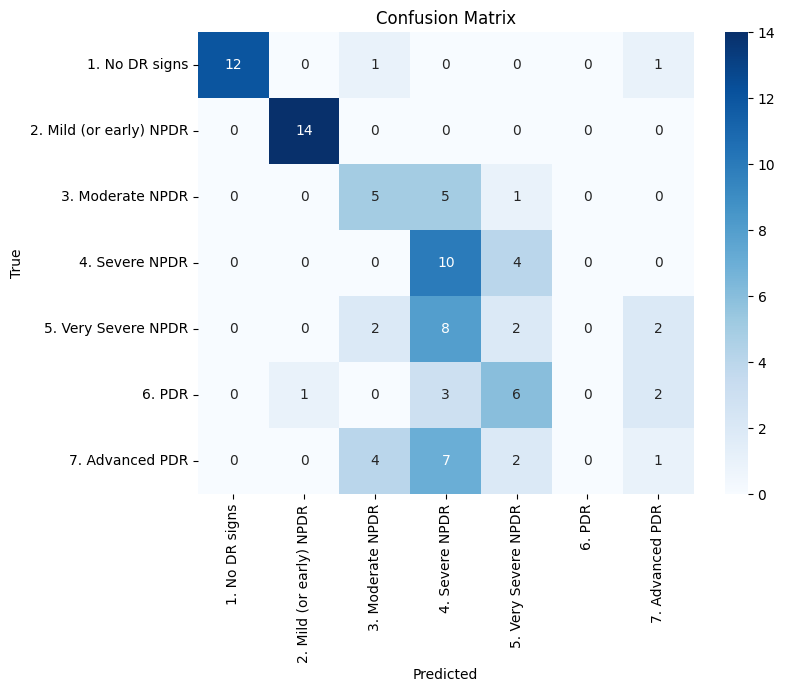

Accuracy: 0.4731
Precision: nan
Recall (Sensitivity): 0.4629
F1-Score: nan
Specificity: 0.8121


<ipython-input-3-ac90a53ee71f>:16: RuntimeWarning: invalid value encountered in divide
  precision = TP / (TP + FP)


In [3]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Compute Metrics
TN = np.diag(cm).sum() - cm.sum(axis=0)
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)

precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)
specificity = TN / (TN + FP)
accuracy = np.trace(cm) / np.sum(cm)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {np.mean(precision):.4f}")
print(f"Recall (Sensitivity): {np.mean(recall):.4f}")
print(f"F1-Score: {np.mean(f1_score):.4f}")
print(f"Specificity: {np.mean(specificity):.4f}")